In [1]:
import pickle
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

In [2]:
# Taken from https://pytorch.org/tutorials/beginner/nn_tutorial.html
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        mnist = pickle.load(f, encoding="latin-1")

In [4]:
(training, validation, test) = mnist
 
_train, y_train = torch.tensor(training[0]), torch.tensor(training[1])
x_val, y_val = torch.tensor(validation[0]), torch.tensor(validation[1])
x_test, y_test = torch.tensor(test[0]), torch.tensor(test[1])

In [5]:
x_train, y_train = torch.tensor(training[0]), torch.tensor(training[1])
x_val, y_val = torch.tensor(validation[0]), torch.tensor(validation[1])
x_test, y_test = torch.tensor(test[0]), torch.tensor(test[1])

In [6]:
len(training[0])

50000

In [7]:
len(training[0][0])

784

In [8]:
def image(a):
    img = np.reshape(a, (28, 28))
    imgplot = plt.imshow(img, cmap = "gray")
    plt.show()

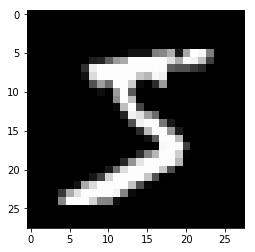

In [9]:
image(training[0][0])

In [10]:
training[1][0]

5

In [11]:
def err(out, label):
    match = out.argmax(dim=1) != label
    a = match.float().mean()
    return a

In [12]:
def traindata(t):
    x = random.randint(0, 49999)
    image(t[0][x])
    print('Label:', t[1][x])

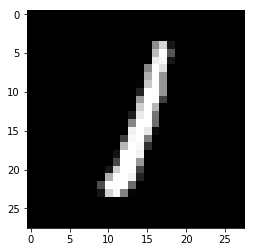

Label: 1


In [13]:
traindata(training)

In [14]:
loss_func = F.cross_entropy

In [15]:
b1 = torch.randn(1, 16, requires_grad=True)
b2 = torch.randn(1, 16, requires_grad=True)
b3 = torch.randn(1, 10, requires_grad=True)
w1 = torch.randn(784, 16, requires_grad=True)
w2 = torch.randn(16, 16, requires_grad=True)
w3 = torch.randn(16, 10, requires_grad=True)

In [16]:
# 3 fully connected layers 784 x 16 x 10
# This model is running on CPU not GPU
def model(d):
    # d is a tensor of 1 by 784
    l1 = d @ w1 + b1
    l2 = l1 @ w2 + b2
    l_out = l2 @ w3 + b3
    return l_out

In [17]:
def zero_grad():
    global b1, b2, b3, w1, w2, w3
    b1.grad.zero_()
    b2.grad.zero_()
    b3.grad.zero_()
    w1.grad.zero_()
    w2.grad.zero_()
    w3.grad.zero_()

In [18]:
def accuracy(out, label):
    match = out.argmax(dim=1) == label
    a = match.float().mean()
    return a

def err(out, label):
    match = out.argmax(dim=1) != label
    a = match.float().mean()
    return a

In [19]:
lr = 0.01
epochs = 100
bs = 64
n = len(x_train)

In [21]:
with torch.no_grad():
    pred = model(x_val)
    print(f'Initial acc {accuracy(pred, y_val)}')

Initial acc 0.08579999953508377


In [22]:
def fit():
    global b1, b2, b3, w1, w2, w3
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end]
            yb = y_train[start:end]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                b1 -= b1.grad * lr
                b2 -= b2.grad * lr
                b3 -= b3.grad * lr
                w1 -= w1.grad * lr
                w2 -= w2.grad * lr
                w3 -= w3.grad * lr
        
                zero_grad()
        if e % 10 == 0:
            print(f'Epoch {e} acc {accuracy(model(x_val), y_val)}')

    print(f'Final acc {accuracy(model(x_val), y_val)}')

In [23]:
fit()

Epoch 0 acc 0.5543000102043152
Epoch 10 acc 0.7110000252723694
Epoch 20 acc 0.7703999876976013
Epoch 30 acc 0.810699999332428
Epoch 40 acc 0.8374999761581421
Epoch 50 acc 0.8547000288963318
Epoch 60 acc 0.8646000027656555
Epoch 70 acc 0.8716999888420105
Epoch 80 acc 0.8776999711990356
Epoch 90 acc 0.8804000020027161
Final acc 0.8835999965667725


In [26]:
# Test model on a random sample
i = random.randint(0, 49999)
pred = model(x_train[i])
print(f"actual {y_train[i]} pred {pred.argmax()}")

actual 7 pred 7


In [29]:
# Average accuray for complete dataset
pred = model(x_train)
match = pred.argmax(dim=1) == y_train
match.float().mean()

tensor(0.8720)

In [30]:
# Welcome to the world of torch.nn.Module to simplify model and parameter management

from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Parameter(torch.randn(1, 16, requires_grad=True))
        self.b2 = nn.Parameter(torch.randn(1, 16, requires_grad=True))
        self.b3 = nn.Parameter(torch.randn(1, 10, requires_grad=True))
        self.w1 = nn.Parameter(torch.randn(784, 16, requires_grad=True))
        self.w2 = nn.Parameter(torch.randn(16, 16, requires_grad=True))
        self.w3 = nn.Parameter(torch.randn(16, 10, requires_grad=True))

    def forward(self, d):
        l1 = d @ self.w1 + self.b1
        l2 = l1 @ self.w2 + self.b2
        l_out = l2 @ self.w3 + self.b3
        return l_out

In [31]:
def fit2():
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end]
            yb = y_train[start:end]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        if e % 10 == 0:
            print(f'Epoch {e} acc {accuracy(model(x_val), y_val)}')

    print(f'Final acc {accuracy(model(x_val), y_val)}')

In [32]:
model = Mnist_NN()

In [33]:
fit2()

Epoch 0 acc 0.44769999384880066
Epoch 10 acc 0.730400025844574
Epoch 20 acc 0.7883999943733215
Epoch 30 acc 0.8162000179290771
Epoch 40 acc 0.8338000178337097
Epoch 50 acc 0.8479999899864197
Epoch 60 acc 0.8572999835014343
Epoch 70 acc 0.867900013923645
Epoch 80 acc 0.8748999834060669
Epoch 90 acc 0.8823000192642212
Final acc 0.8853999972343445


In [34]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# dev = torch.device("cuda")
# dev = torch.device("cpu")

dev

device(type='cuda')

In [35]:
# Now run the model using GPU
model_dev = Mnist_NN().to(dev)

x_test_dev = x_test.to(dev)
y_test_dev = y_test.to(dev)

x_val_dev = x_val.to(dev)
y_val_dev = y_val.to(dev)

x_train_dev = x_train.to(dev)
y_train_dev = y_train.to(dev)

In [36]:
def fit3():
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end].to(dev)
            yb = y_train[start:end].to(dev)
            pred = model_dev(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model_dev.parameters():
                    p -= p.grad * lr
                model_dev.zero_grad()
        if e % 10 == 0:
            print(f'Epoch {e} acc test {accuracy(model_dev(x_test_dev), y_test_dev)}')
            print(f'Epoch {e} acc val {accuracy(model_dev(x_val_dev), y_val_dev)}')
            print(f'Epoch {e} acc train {accuracy(model_dev(x_train_dev), y_train_dev)}')

    print(f'Final acc test {accuracy(model_dev(x_test_dev), y_test_dev)}')
    print(f'Final acc val {accuracy(model_dev(x_val_dev), y_val_dev)}')
    print(f'Final acc train {accuracy(model_dev(x_train_dev), y_train_dev)}')

In [37]:
fit3()

Epoch 0 acc test 0.5210999846458435
Epoch 0 acc val 0.5374999642372131
Epoch 0 acc train 0.517520010471344
Epoch 10 acc test 0.6956999897956848
Epoch 10 acc val 0.7105000019073486
Epoch 10 acc train 0.6912199854850769
Epoch 20 acc test 0.774899959564209
Epoch 20 acc val 0.7876999974250793
Epoch 20 acc train 0.7666800022125244
Epoch 30 acc test 0.8130999803543091
Epoch 30 acc val 0.821899950504303
Epoch 30 acc train 0.8048399686813354
Epoch 40 acc test 0.833299994468689
Epoch 40 acc val 0.8387999534606934
Epoch 40 acc train 0.8258199691772461
Epoch 50 acc test 0.8477999567985535
Epoch 50 acc val 0.8526999950408936
Epoch 50 acc train 0.8392799496650696
Epoch 60 acc test 0.8571999669075012
Epoch 60 acc val 0.8625999689102173
Epoch 60 acc train 0.8502599596977234
Epoch 70 acc test 0.8660999536514282
Epoch 70 acc val 0.8698999881744385
Epoch 70 acc train 0.8587799668312073
Epoch 80 acc test 0.8720999956130981
Epoch 80 acc val 0.8763999938964844
Epoch 80 acc train 0.8654399514198303
Epoch 90

In [38]:
x = np.linspace(0, 101, 101)
test_y_dev = torch.zeros(101, device=dev)
val_y_dev = torch.zeros(101, device=dev)
train_y_dev = torch.zeros(101, device=dev)

In [39]:
# Train the model on GPU and keep track of accuracy on test, validation and training dataset to plot the trend
model_dev = Mnist_NN().to(dev)
def fit4():
    test_y_dev[0] = accuracy(model_dev(x_test_dev), y_test_dev)
    val_y_dev[0] = accuracy(model_dev(x_val_dev), y_val_dev)
    train_y_dev[0] = accuracy(model_dev(x_train_dev), y_train_dev)
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end].to(dev)
            yb = y_train[start:end].to(dev)
            pred = model_dev(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model_dev.parameters():
                    p -= p.grad * lr
                model_dev.zero_grad()
                
        with torch.no_grad():
            test_y_dev[e + 1] = accuracy(model_dev(x_test_dev), y_test_dev)
            val_y_dev[e + 1] = accuracy(model_dev(x_val_dev), y_val_dev)
            train_y_dev[e + 1] = accuracy(model_dev(x_train_dev), y_train_dev)
        
    plt.plot(x, test_y_dev.cpu().numpy(), label='test')
    plt.plot(x, val_y_dev.cpu().numpy(), label='val')
    plt.plot(x, train_y_dev.cpu().numpy(), label='train')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("Simple Plot")
    plt.legend()
    plt.show()

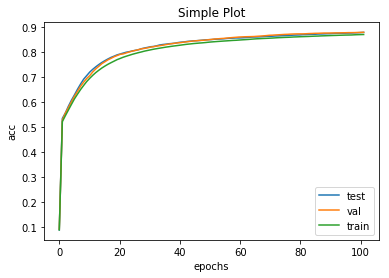

In [40]:
fit4()

In [42]:
print(f'Final acc test {test_y_dev[100]}')
print(f'Final acc val {val_y_dev[100]}')
print(f'Final acc train {train_y_dev[100]}')

Final acc test 0.8795999884605408
Final acc val 0.8801999688148499
Final acc train 0.8711400032043457


In [43]:
# The accuracy is close to 90%, I will try to increase the accuracy using CNN in a different notebook.